In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#download bbc text
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-08-11 19:14:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  21.7MB/s    in 0.2s    

2020-08-11 19:14:57 (21.7 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [3]:
#parameters

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [4]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [5]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) #skipping the columns
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

In [6]:
print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

In [7]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences( train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

In [9]:
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

449
120
200
120
192
120


In [10]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length,  truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [11]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 128)          41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 100,398
Trainable params: 100,398
Non-trainable params: 0
_________________________________________________________________


In [13]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 11s - loss: 1.6631 - accuracy: 0.2185 - val_loss: 1.5663 - val_accuracy: 0.3326
Epoch 2/30
56/56 - 10s - loss: 1.2517 - accuracy: 0.4298 - val_loss: 1.0317 - val_accuracy: 0.5326
Epoch 3/30
56/56 - 10s - loss: 0.8972 - accuracy: 0.5933 - val_loss: 1.0343 - val_accuracy: 0.5236
Epoch 4/30
56/56 - 10s - loss: 0.7738 - accuracy: 0.6461 - val_loss: 0.7986 - val_accuracy: 0.6360
Epoch 5/30
56/56 - 10s - loss: 0.6425 - accuracy: 0.7073 - val_loss: 0.9942 - val_accuracy: 0.5483
Epoch 6/30
56/56 - 10s - loss: 0.5697 - accuracy: 0.7404 - val_loss: 0.8054 - val_accuracy: 0.6831
Epoch 7/30
56/56 - 10s - loss: 0.5095 - accuracy: 0.7730 - val_loss: 1.0184 - val_accuracy: 0.6000
Epoch 8/30
56/56 - 10s - loss: 0.4836 - accuracy: 0.7961 - val_loss: 0.7617 - val_accuracy: 0.7191
Epoch 9/30
56/56 - 10s - loss: 0.3975 - accuracy: 0.8478 - val_loss: 0.7290 - val_accuracy: 0.7573
Epoch 10/30
56/56 - 10s - loss: 0.3030 - accuracy: 0.8910 - val_loss: 0.8530 - val_accuracy: 0.7416
Epoch 11/

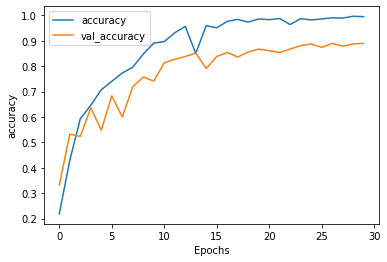

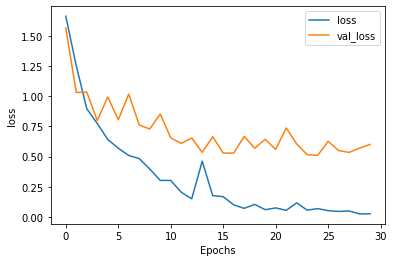

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
model.save('bbc.h5')
import os
print(str(os.path.getsize('./bbc.h5')/1000000) + 'MB')

1.284024MB


**Pretrained embeddings**

In [16]:
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

In [18]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

In [19]:
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
testing_sequences = tokenizer.texts_to_sequences(validation_sentences)
testing_padded = pad_sequences(testing_sequences,  maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [21]:
print(len(sequences[0]))
print(len(padded[0]))

449
120


In [22]:
print(len(testing_sequences[0]))
print(len(testing_padded[0]))

155
120


In [23]:
vocab_size

27284

In [24]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-08-11 19:26:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  32.8MB/s    in 10s     

2020-08-11 19:26:25 (32.8 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          2728500   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120, 128)          84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 2,855,906
Trainable params: 127,406
Non-trainable params: 2,728,500
_________________________________________________________________


In [26]:
num_epochs = 30
history = model.fit(padded, training_label_seq, epochs=num_epochs, validation_data=(testing_padded, validation_label_seq))

Epoch 1/30
56/56 [==============================] - 12s 222ms/step - loss: 0.8199 - accuracy: 0.7803 - val_loss: 0.2526 - val_accuracy: 0.9416
Epoch 2/30
56/56 [==============================] - 11s 199ms/step - loss: 0.2212 - accuracy: 0.9371 - val_loss: 0.2890 - val_accuracy: 0.9011
Epoch 3/30
56/56 [==============================] - 11s 197ms/step - loss: 0.1558 - accuracy: 0.9534 - val_loss: 0.1253 - val_accuracy: 0.9528
Epoch 4/30
56/56 [==============================] - 11s 197ms/step - loss: 0.0976 - accuracy: 0.9736 - val_loss: 0.1697 - val_accuracy: 0.9393
Epoch 5/30
56/56 [==============================] - 11s 198ms/step - loss: 0.1022 - accuracy: 0.9685 - val_loss: 0.2137 - val_accuracy: 0.9281
Epoch 6/30
56/56 [==============================] - 11s 200ms/step - loss: 0.0813 - accuracy: 0.9736 - val_loss: 0.1241 - val_accuracy: 0.9506
Epoch 7/30
56/56 [==============================] - 11s 198ms/step - loss: 0.1077 - accuracy: 0.9646 - val_loss: 0.1125 - val_accuracy: 0.9640

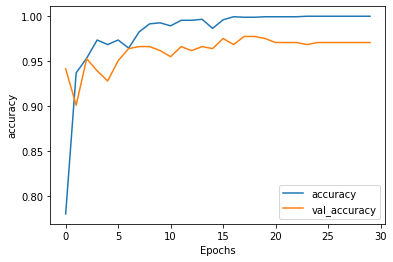

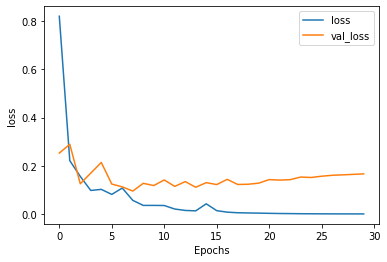

In [27]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
model.save('bbc_1.h5')
import os
print(str(os.path.getsize('./bbc_1.h5')/1000000) + 'MB')

12.51784MB
